In [51]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json

In [52]:
RANDOM_STATE = 42

# Read Data

In [53]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [54]:
read_query = make_read_query()

In [55]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,...,n_orders,avg_order_items,avg_item_value,avg_order_value,purchased_categories,first_order_n_items,first_order_value,first_order_categories,lifetime_status,segment
0,56219,60,F,United States,Philadelphia,Facebook,2019-01-02 00:06:00,2021-05-27 23:07:12,2021-05-27 23:07:12,876.0,...,1,1.0,74.990,74.990,{Jeans},1.0,74.99,{Jeans},Active,One-Off Customers
1,72034,70,F,South Korea,Seoul,Organic,2019-01-02 00:36:00,2021-07-30 12:35:12,2023-04-21 14:50:59,940.0,...,2,1.0,221.500,221.500,"{Intimates,""Outerwear & Coats""}",1.0,44.00,{Intimates},Churned,High Value Item Orderers
2,21731,65,F,China,Harbin,Email,2019-01-02 01:47:00,2023-09-17 22:23:37,2023-09-17 22:23:37,1719.0,...,1,4.0,60.985,243.940,"{""Blazers & Jackets"",Maternity,""Tops & Tees"",A...",4.0,243.94,"{""Blazers & Jackets"",Maternity,""Tops & Tees"",A...",Active,One-Off Customers
3,39594,17,M,China,Shenzhen,Search,2019-01-02 03:00:00,2019-02-11 03:06:43,2019-10-25 02:29:03,40.0,...,2,1.0,35.975,35.975,"{""Fashion Hoodies & Sweatshirts"",Accessories}",1.0,51.96,"{""Fashion Hoodies & Sweatshirts""}",Churned,Single-Item Orderers
4,2000,30,F,China,Hefei,Search,2019-01-02 03:19:00,NaT,NaT,NaN,...,0,NaN,NaN,NaN,None,NaN,NaN,None,Inactive,Never Ordered


In [56]:
users_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84011 entries, 0 to 84010
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      84011 non-null  int64         
 1   age                     84011 non-null  int64         
 2   gender                  84011 non-null  object        
 3   country                 84011 non-null  object        
 4   city                    84011 non-null  object        
 5   traffic_source          84011 non-null  object        
 6   created_at              84011 non-null  datetime64[ns]
 7   first_order_timestamp   69073 non-null  datetime64[ns]
 8   last_order_timestamp    69073 non-null  datetime64[ns]
 9   days_to_activation      69073 non-null  float64       
 10  active_days             69073 non-null  float64       
 11  inactive_days           69073 non-null  float64       
 12  avg_days_to_order       30731 non-null  float6

In [57]:
users_enriched.describe()

,id,age,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,active_days,inactive_days,avg_days_to_order,std_days_to_order,n_orders,avg_order_items,avg_item_value,avg_order_value,first_order_n_items,first_order_value
count,84011.000000,84011.000000,84011,69073,69073,69073.000000,69073.000000,69073.000000,30731.000000,69073.000000,84011.000000,69073.000000,69073.000000,69073.000000,69073.000000,69073.000000
mean,50046.114747,41.056743,2021-06-14 10:42:19.902130432,2022-07-16 08:15:15.045711104,2023-01-26 08:13:51.547237632,404.987101,193.778872,738.996077,275.870945,32.532509,1.490591,1.498907,59.255161,86.006317,1.447541,85.800945
min,1.000000,12.000000,2019-01-02 00:06:00,2019-01-06 02:25:41,2019-01-06 02:25:41,0.000000,0.000000,379.000000,0.000000,0.000000,0.000000,1.000000,0.490000,0.490000,1.000000,0.490000
25%,25058.500000,26.000000,2020-02-20 04:11:00,2021-09-13 00:20:14,2022-08-05 07:17:34,93.000000,0.000000,453.000000,83.000000,0.000000,1.000000,1.000000,30.245000,36.083333,1.000000,29.500000
50%,50075.000000,41.000000,2021-05-23 03:56:00,2022-10-20 18:26:08,2023-06-03 08:41:08,284.000000,0.000000,611.000000,197.000000,0.000000,1.000000,1.000000,47.432500,64.240000,1.000000,55.000000
75%,75034.500000,56.000000,2022-09-24 04:51:30,2023-07-30 10:50:57,2023-11-08 10:31:21,617.000000,269.000000,913.000000,379.000000,0.000000,2.000000,2.000000,70.982500,109.231429,2.000000,109.500000
max,100000.000000,70.000000,2024-01-16 19:46:14.316147,2024-01-21 10:09:51.990337,2024-01-21 12:55:19.720387,1828.000000,1784.000000,2220.000000,1744.000000,1101.000000,40.000000,4.000000,999.000000,1341.490000,4.000000,1341.490000
std,28875.397764,17.035458,NaN,NaN,NaN,386.041580,334.320750,366.613521,268.147382,97.142237,1.363647,0.743731,50.940926,79.785017,0.806956,93.215557


# Data Preparation

In [58]:
inactive_users = users_enriched.loc[users_enriched.n_orders==0].copy()
one_off_customers = users_enriched.loc[users_enriched.n_orders==1].copy()
repeat_purchasers = users_enriched.loc[users_enriched.n_orders>1].copy()

print('Repeat Purchasers:', repeat_purchasers.shape[0], 
      'One-Off Customers', one_off_customers.shape[0], 
      'Inactive Users', inactive_users.shape[0])

Repeat Purchasers: 30731 One-Off Customers 38342 Inactive Users 14938


In [59]:
one_off_customers['segment'] = 'One-Off Customers'
inactive_users['segment'] = 'Never Ordered'

In [60]:
CLUSTERING_FEATURES = ['active_days', 'avg_days_to_order', 'avg_order_items', 'avg_item_value']
X = repeat_purchasers[CLUSTERING_FEATURES]

In [61]:
X.describe()

,active_days,avg_days_to_order,avg_order_items,avg_item_value
count,30731.000000,30731.000000,30731.000000,30731.000000
mean,435.550031,275.870945,1.560867,59.684197
std,381.994811,268.147382,0.651237,37.150316
min,0.000000,0.000000,1.000000,4.470000
25%,118.000000,83.000000,1.000000,36.790000
50%,332.000000,197.000000,1.000000,51.460000
75%,672.000000,379.000000,2.000000,71.968750
max,1784.000000,1744.000000,4.000000,745.000000


In [62]:
def plot_histograms(df, columns=None, width=14, height=7, bins=20):
    columns = df.columns if columns is None else columns
    n_subplots = len(columns)
    n_subplot_rows = round(np.sqrt(n_subplots))
    n_subplot_cols = n_subplots / n_subplot_rows

    n_subplot_cols = int(n_subplot_cols) + 1 if n_subplot_cols % 1 > 0 else int(n_subplot_cols)
    
    fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols)
    fig.set_figwidth(14)
    fig.set_figheight(7)

    for i, col in enumerate(columns):
        ax_row = i // n_subplot_cols
        ax_col = i % n_subplot_cols
        ax = axs[ax_row,ax_col]
        ax.set_title(col)
        df[col].hist(bins=bins, ax=ax)

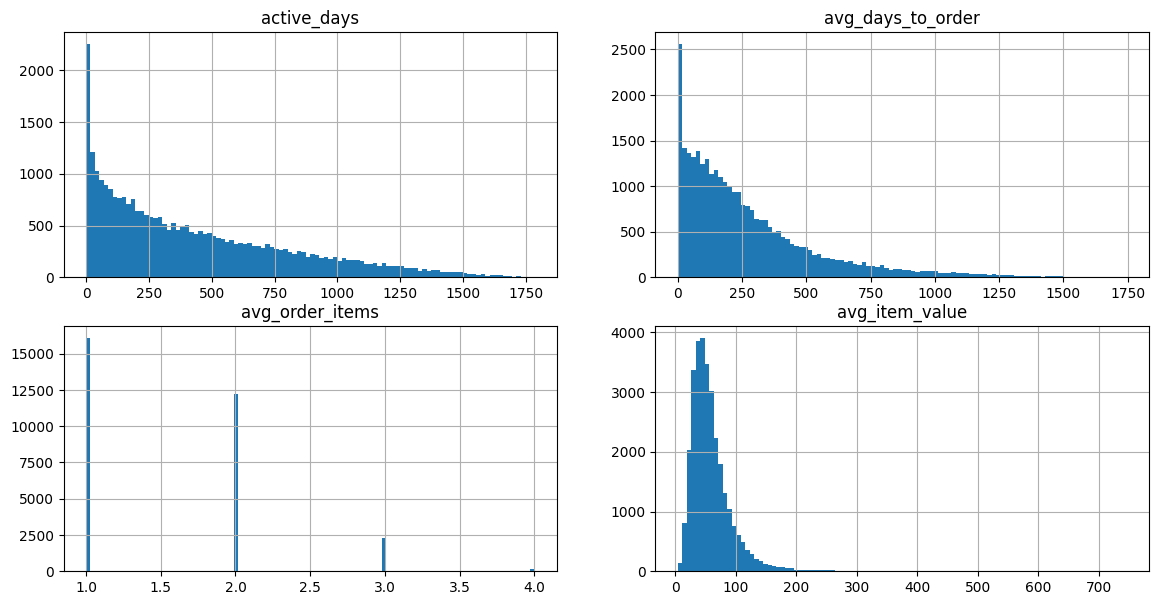

In [63]:
plot_histograms(X, bins=100)

<Axes: >

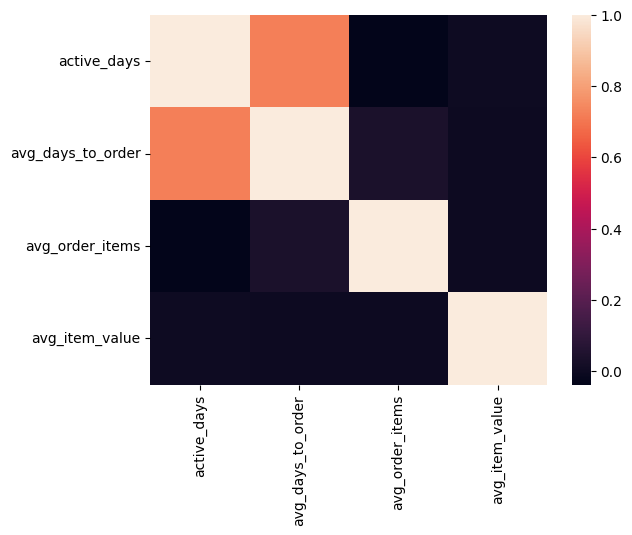

In [64]:
sns.heatmap(X.corr())

# Clustering Repeat Purchasers

In [65]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []        
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)
        silhouette = silhouette_score(X, y)
        inertia = model.inertia_ if model_type == KMeans else None
        
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model, 
            'silhouette_score': silhouette,
            'inertia': inertia if inertia else cost
        }
        
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Inertia: {inertia}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [66]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

In [67]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [69]:
hyperparams = [{'n_clusters': i} for i in range(2, 11)]
results = search_clustering_hyperparams(KMeans, hyperparams, X_scaled, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.32758751406812736 | Inertia: 86341.73503510578
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.3120242403254903 | Inertia: 67999.08616459862
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.33088962055781523 | Inertia: 55352.0474955337
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.32391763800529694 | Inertia: 48027.515292827076
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.33055574193911935 | Inertia: 42316.16496184256
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.3279108130323375 | Inertia: 38552.56369208878
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.29934586568871263 | Inertia: 37199.26278450469
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.28412223583901475 | Inertia: 35457.7157116009
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.2924907959904365 | Inertia: 31868.595707277083


<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

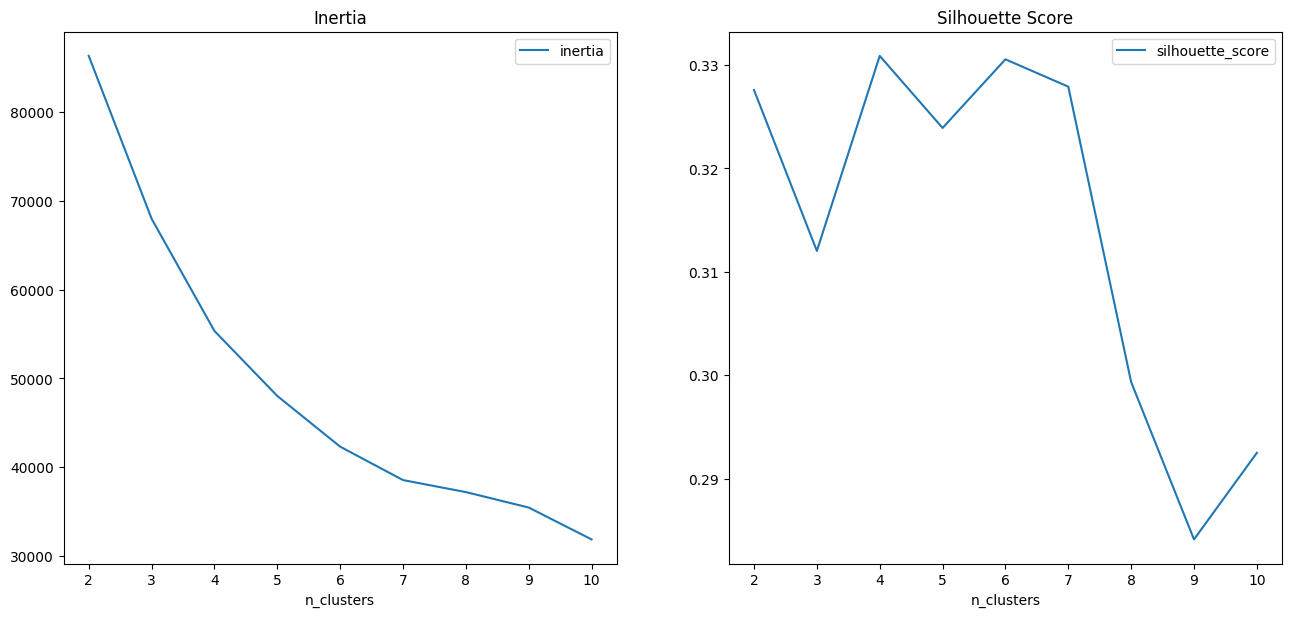

In [70]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
results.plot(x='n_clusters', y='inertia', ax=axs[0])

axs[1].set_title('Silhouette Score')
results.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [71]:
model = results.loc[results.n_clusters==7, 'model'].iloc[0]
Xy = X.copy()
Xy['segment'] = model.labels_
repeat_purchasers['segment'] = model.labels_

In [73]:
cluster_centers = scaler.inverse_transform(model.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=CLUSTERING_FEATURES)
cluster_centers

,active_days,avg_days_to_order,avg_order_items,avg_item_value
0,797.733972,403.396645,1.000000,53.814105
1,172.474831,122.038601,2.199298,54.591961
2,310.195703,223.174216,1.347271,163.271588
3,186.979428,123.218359,1.000000,50.032724
4,752.331193,413.195940,2.154101,56.749192
5,1081.661241,1001.106307,1.587487,56.423404


In [79]:
Xy['segment'].value_counts()

segment
3    8934
1    8270
0    5013
4    4832
5    1962
2    1720
Name: count, dtype: int64

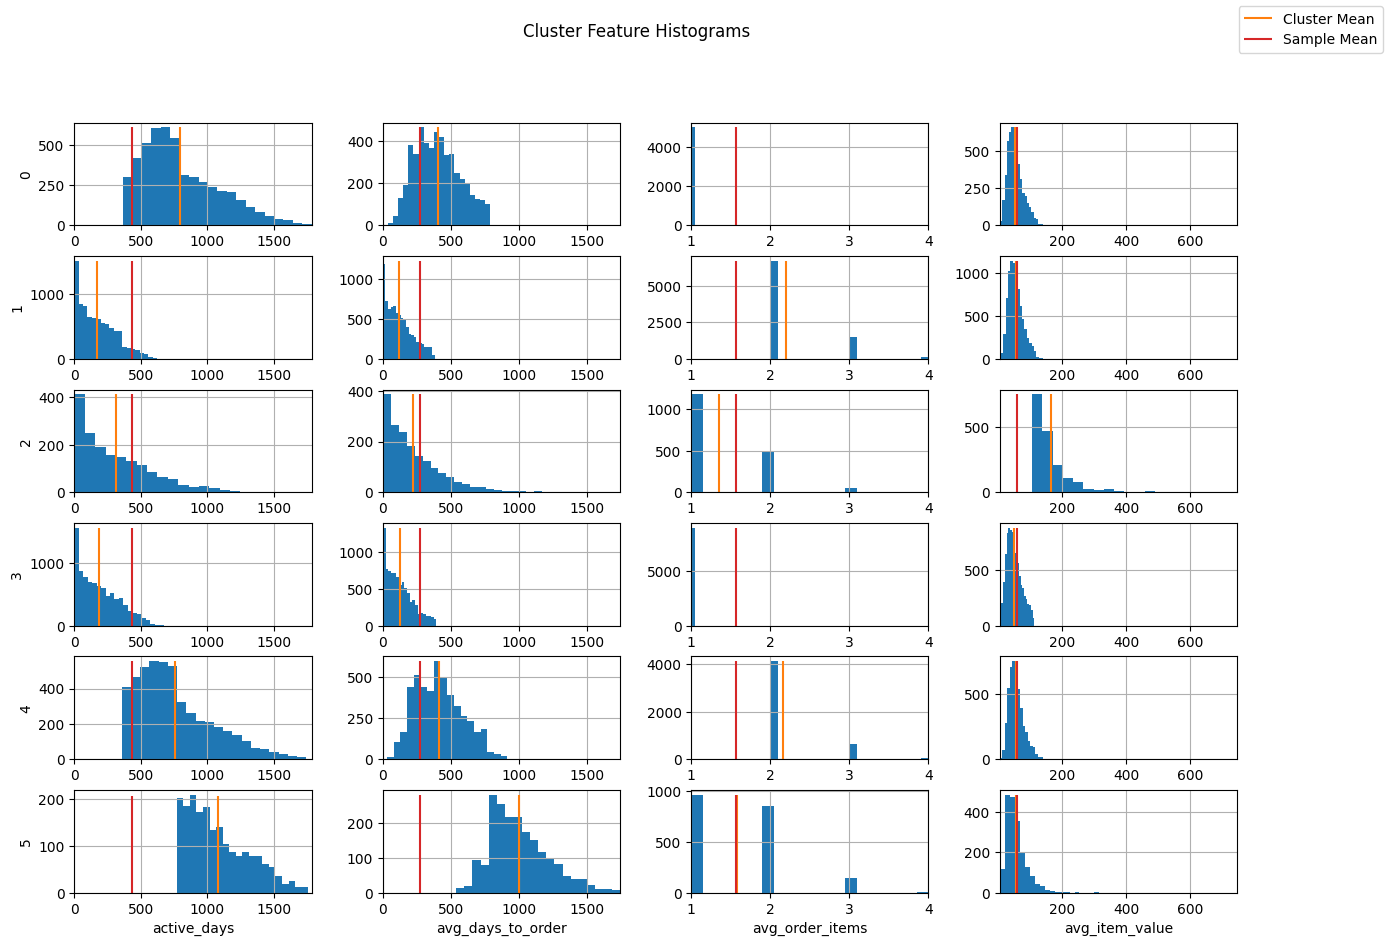

In [80]:
plot_clusters(X, model.labels_)

In [81]:
print('Cluster Mean / Sample Mean:', Xy.groupby('segment').mean() / Xy.drop(columns='segment').mean(), sep='\n')
print('\n'+80*'-'+'\n', 'Cluster Mean:', Xy.groupby('segment').mean(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Std:', Xy.groupby('segment').std(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Min:', Xy.groupby('segment').min(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Max:', Xy.groupby('segment').max(), sep='\n')

Cluster Mean / Sample Mean:
         active_days  avg_days_to_order  avg_order_items  avg_item_value
segment                                                                 
0           1.829482           1.460694         0.640670        0.901422
1           0.396263           0.442639         1.408931        0.915013
2           0.712667           0.809519         0.862669        2.736486
3           0.428629           0.445878         0.640670        0.838265
4           1.728969           1.500117         1.380251        0.950719
5           2.483778           3.630738         1.014557        0.945632

--------------------------------------------------------------------------------

Cluster Mean:
         active_days  avg_days_to_order  avg_order_items  avg_item_value
segment                                                                 
0         796.831039         402.963096         1.000000       53.800637
1         172.592382         122.111245         2.199154       54.611807

In [82]:
segment_map = {
    0: 'Loyal Single-Item Orderers',
    1: 'Multi-Item Orderers',
    2: 'High Value Item Orderers',
    3: 'Single-Item Orderers',
    4: 'Loyal Multi-Item Orderers',
    5: 'Long Time-To-Order',
}

In [83]:
repeat_purchasers['segment'] = Xy['segment'].map(segment_map) 

In [84]:
repeat_purchasers

,id,age,gender,country,city,traffic_source,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,...,n_orders,avg_order_items,avg_item_value,avg_order_value,purchased_categories,first_order_n_items,first_order_value,first_order_categories,lifetime_status,segment
1,72034,70,F,South Korea,Seoul,Organic,2019-01-02 00:36:00.000000,2021-07-30 12:35:12.000000,2023-04-21 14:50:59.000000,940.0,...,2,1.0,221.500000,221.500000,"{Intimates,""Outerwear & Coats""}",1.0,44.00,{Intimates},Churned,High Value Item Orderers
3,39594,17,M,China,Shenzhen,Search,2019-01-02 03:00:00.000000,2019-02-11 03:06:43.000000,2019-10-25 02:29:03.000000,40.0,...,2,1.0,35.975000,35.975000,"{""Fashion Hoodies & Sweatshirts"",Accessories}",1.0,51.96,"{""Fashion Hoodies & Sweatshirts""}",Churned,Single-Item Orderers
5,67509,26,M,United States,Phoenixville,Search,2019-01-02 03:35:00.000000,2020-07-28 11:30:55.000000,2024-01-14 02:16:17.000000,573.0,...,6,2.0,58.932222,88.398333,"{""Outerwear & Coats"",""Tops & Tees"",""Outerwear ...",2.0,183.20,"{""Outerwear & Coats"",""Tops & Tees""}",Active,Loyal Multi-Item Orderers
8,63206,28,F,China,Chongqing,Search,2019-01-02 05:11:00.000000,2022-03-25 02:21:48.000000,2023-01-02 04:07:08.000000,1177.0,...,4,1.0,29.812000,37.265000,"{Intimates,Maternity,Intimates,Jeans,Plus}",1.0,17.49,{Intimates},Churned,Single-Item Orderers
10,11622,23,F,China,Taizhou,Display,2019-01-02 05:23:00.000000,2019-01-19 04:49:29.000000,2020-08-26 03:14:37.000000,16.0,...,3,1.0,25.817500,34.423333,"{""Socks & Hosiery"",Intimates,Intimates,Skirts}",1.0,28.00,"{""Socks & Hosiery""}",Churned,Loyal Single-Item Orderers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83994,20449,45,F,China,Suzhou,Search,2024-01-16 18:25:51.425022,2024-01-17 15:08:38.425022,2024-01-17 18:06:01.425022,0.0,...,4,2.0,78.111429,136.695000,"{""Fashion Hoodies & Sweatshirts"",""Outerwear & ...",2.0,268.95,"{""Fashion Hoodies & Sweatshirts"",""Outerwear & ...",Churned,Multi-Item Orderers
83996,69815,44,M,Spain,Sant Cugat del Vallès,Search,2024-01-16 18:36:41.382770,2024-01-17 16:33:46.382770,2024-01-18 15:47:10.382770,0.0,...,4,2.0,43.077500,86.155000,"{Jeans,""Tops & Tees"",""Tops & Tees"",Underwear,U...",1.0,62.95,{Jeans},Churned,Multi-Item Orderers
84003,71817,21,M,China,Tonghua,Search,2024-01-16 19:10:46.768851,2024-01-17 15:53:45.768851,2024-01-17 17:25:07.768851,0.0,...,2,2.0,107.663333,161.495000,"{Shorts,""Sleep & Lounge"",""Tops & Tees""}",1.0,55.00,{Shorts},Churned,Multi-Item Orderers
84004,31640,34,M,France,Bayonne,Organic,2024-01-16 19:18:00.384703,2024-01-17 18:43:28.384703,2024-01-17 19:09:32.384703,0.0,...,2,1.0,82.555000,82.555000,"{Accessories,""Suits & Sport Coats""}",1.0,149.03,{Accessories},Churned,Single-Item Orderers


In [85]:
repeat_purchasers.segment.value_counts()

segment
Single-Item Orderers          8934
Multi-Item Orderers           8270
Loyal Single-Item Orderers    5013
Loyal Multi-Item Orderers     4832
Long Time-To-Order            1962
High Value Item Orderers      1720
Name: count, dtype: int64

In [86]:
segment_cltv = repeat_purchasers.groupby('segment')[['active_days', 'avg_days_to_order', 'avg_order_value']].mean()
segment_cltv['cltv'] = (segment_cltv['active_days'] / segment_cltv['avg_days_to_order']) * segment_cltv['avg_order_value']
segment_cltv

,active_days,avg_days_to_order,avg_order_value,cltv
segment,,,,
High Value Item Orderers,310.402326,223.322674,207.186888,287.974752
Long Time-To-Order,1081.809378,1001.615189,80.187905,86.608139
Loyal Multi-Item Orderers,753.052566,413.838576,106.377655,193.572980
Loyal Single-Item Orderers,796.831039,402.963096,59.812139,118.274277
Multi-Item Orderers,172.592382,122.111245,103.779266,146.681910
Single-Item Orderers,186.689389,123.004701,53.353378,80.976658


In [88]:
customers_segmented = pd.concat([repeat_purchasers, one_off_customers, inactive_users])\
                        .sort_values('created_at')

In [89]:
customers_segmented.groupby(['segment'])['id'].count()

segment
High Value Item Orderers       1720
Long Time-To-Order             1962
Loyal Multi-Item Orderers      4832
Loyal Single-Item Orderers     5013
Multi-Item Orderers            8270
Never Ordered                 14938
One-Off Customers             38342
Single-Item Orderers           8934
Name: id, dtype: int64

In [90]:
customers_segmented.groupby(['segment', 'lifetime_status'])['id'].count()

segment                     lifetime_status
High Value Item Orderers    Active               285
                            Churned             1435
Long Time-To-Order          Active              1792
                            Churned              170
Loyal Multi-Item Orderers   Active              2621
                            Churned             2211
Loyal Single-Item Orderers  Active              3106
                            Churned             1907
Multi-Item Orderers         Active               250
                            Churned             8020
Never Ordered               Inactive           14938
One-Off Customers           Active             38342
Single-Item Orderers        Active               409
                            Churned             8525
Name: id, dtype: int64

# Save Pipeline 

In [91]:
pipe = Pipeline([('scaler', scaler), ('kmeans', model)])

In [95]:
# with open('../models/cust_segment_pipe.pkl', 'wb') as f:
#     pkl.dump(pipe, f)

In [96]:
with open('../models/cust_segment_pipe.pkl', 'rb') as f:
    pipe_loaded = pkl.load(f)

In [97]:
y = pipe_loaded.predict(X)
(y == model.labels_).all()

np.True_

In [98]:
with open('../models/cust_segment_map.json', 'w') as f:
    json.dump(segment_map, f)

In [101]:
with open('../models/cust_segment_map.json', 'r') as f:
    segment_map_ = json.load(f)

In [102]:
segment_map_

{'0': 'Loyal Single-Item Orderers',
 '1': 'Multi-Item Orderers',
 '2': 'High Value Item Orderers',
 '3': 'Single-Item Orderers',
 '4': 'Loyal Multi-Item Orderers',
 '5': 'Long Time-To-Order'}